Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [22]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import glob
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import plot_model


In [23]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [24]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("D:\\Upgrad\\Assignment-Melanoma detection\\Skin cancer ISIC The International Skin Imaging Collaboration\\train")
data_dir_test = pathlib.Path('D:\\Upgrad\Assignment-Melanoma detection\\Skin cancer ISIC The International Skin Imaging Collaboration\\test')

In [25]:
#verification
data_dir_train

WindowsPath('D:/Upgrad/Assignment-Melanoma detection/Skin cancer ISIC The International Skin Imaging Collaboration/train')

In [26]:
#Number of training and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:<br>
defining the batch size and the image dimensions

In [27]:
batch_size = 32
img_height = 180
img_width = 180

###  Creating training and validation dataset

Use 80% of the images for training, and 20% for validation.

Create train & validation dataset from the train directory with a batch size of 32. Also, resizing the images to 180*180.

In [28]:
#defining the training dataset and the validation dataset, image dimensions are also set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = data_dir_train, image_size = (img_height, img_width), seed = 123, validation_split = 0.2, subset = 'training' )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = data_dir_train, image_size = (img_height, img_width), seed = 123, validation_split = 0.2, subset = 'validation' )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [29]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

### Checking the shape of the image dataset and corresponding labels

In [30]:
for images, labels in train_ds:
    print(images.shape)
    print(labels.shape)
    break

(32, 180, 180, 3)
(32,)


In the above code snippet<br>
images.shape gives (batch_size, image_height, image_width, no. of channels(RGB))<br>
32 is the batch size, 180x180 is the dimension of the image matrix, 3 is the no. of channels-RGB<br>
labels.shape gives (batch_size). Here the value is 32, corresponding to the batch size of the images

### Class names in the dataset

Class names in the dataset are extracted using the code given below and assigned to variable class_names

In [31]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Checking number of training images in each class

In [32]:
# Loop over the classes
for class_dir in class_names:
    # Get a list of all the image files for this class
    image_files = os.listdir(os.path.join(data_dir_train, class_dir))
    print(len(image_files))

114
376
95
438
357
462
77
181
139


It can be seen from the above that there is a class imbalance. Notwithstanding, we'll try to build the models from base

In [33]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

### Visualizing the data
Plotting one each image from each class. It can also be seen that all images are of size 180x180

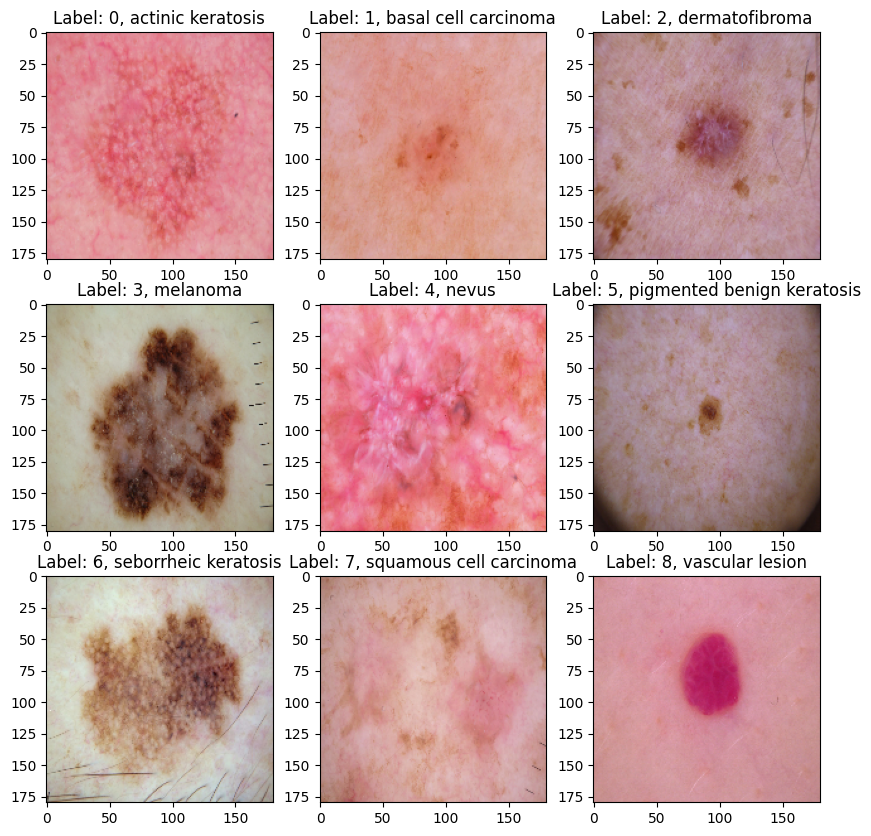

In [34]:
class_list = []

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(2):
    for image, label in zip(images, labels):
        if label.numpy() not in class_list:
            class_list.append(label.numpy())
            ax = plt.subplot(3, 3, label.numpy() + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(f'Label: {label.numpy()}, {class_names[int(label.numpy())]}')
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

### Checking maximum value of RGB in training dataset

In [36]:
red_max = tf.Variable(0, dtype=tf.float32)
green_max = tf.Variable(0, dtype=tf.float32)
blue_max = tf.Variable(0, dtype=tf.float32)
for image in images:
    for i in images:
        if tf.reduce_max(i[:,0]) > red_max:
            red_max = tf.reduce_max(i[:,0])
        if tf.reduce_max(i[:,1]) > green_max:
            green_max = tf.reduce_max(i[:,1])
        if tf.reduce_max(i[:,2]) > blue_max:
            blue_max = tf.reduce_max(i[:,2])

print(f"Max value of red: {red_max}")
print(f"Max value of green: {green_max}")
print(f"Max value of green: {blue_max}")

     

Max value of red: 254.625
Max value of green: 254.5
Max value of green: 254.5


#### It can be seen that the max value of Red, Green, Blue is 255. The range is from 0 to 255

#### Defining the model and rescaling the max value of RGB between 0 and 1

<span style="color:red">Model explanations are done only for the first instance since explanations essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.</span>.

In [37]:
## Model explanations are done only for the first istance since it is essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.
model = Sequential()#defining a sequential CNN model.

# model architecture
#rescaling the RGB values so that the values are smaller.
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model.add(Conv2D(32, (3, 3), padding='same'))#convolution layer with 3x3 window or the kernel, padding= 'same' means the output will be of the same dimensions as the input to this layer.
model.add(Activation('relu'))#activation function for the convolution layer
model.add(MaxPooling2D(pool_size=(2, 2)))#Maxpooling layer-derives maximum values in a matrix of 2x2. Basically halves the dimensions in effect

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())#Flattening the matrix to 1D vector for the dense layer to act upon
model.add(Dense(128))#Dense layer(the normal neural network)
model.add(Activation('relu'))
model.add(Dense(9))#FInal dense layer with the number of neurons equal to the numer of classes.
model.add(Activation('softmax'))#Softmax function for the probabilities of each classes


Summary of the model shows the number of layers, number of parameters to be trained, dimensions, feature sizes etc

In [38]:
model.summary()#Summary of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 90, 90, 64)        0         
                                                      

Plotting the model for more easy understanding

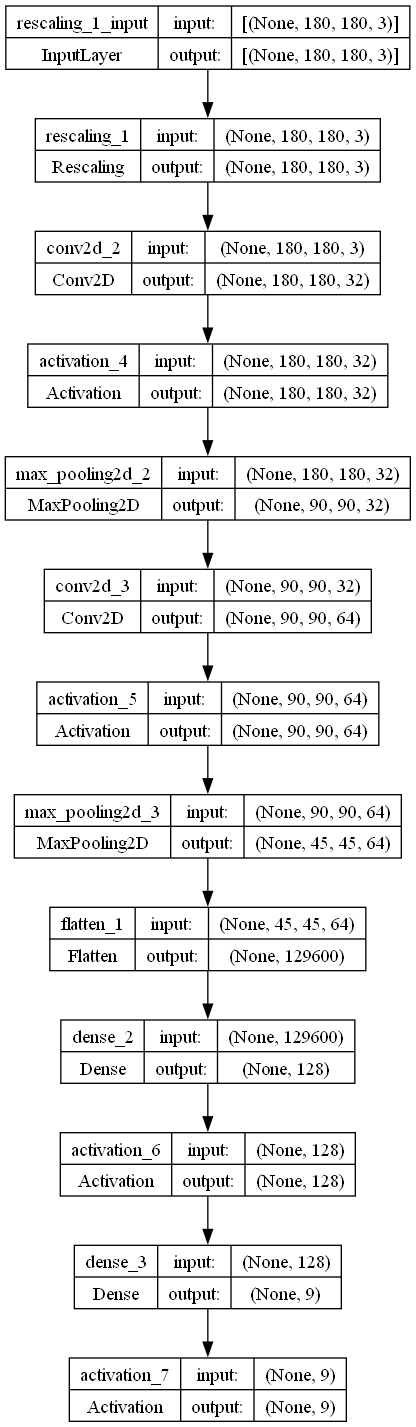

In [39]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
#setting check points and early stop to monitor the accuracy, save the model when max accuracy is observed ie. when accuracy no more improves. Stops at maximum accuracy observed to save resources and time

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [41]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
#defining the number of epochs, traning dataset, validation dataset, callbacks
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


56/56 [==============================] - ETA: 0s - loss: 2.7144 - accuracy: 0.1998
Epoch 1: val_accuracy improved from -inf to 0.20805, saving model to model.h5


d:\Python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 52s 812ms/step - loss: 2.7144 - accuracy: 0.1998 - val_loss: 2.0724 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.8573 - accuracy: 0.3153
Epoch 2: val_accuracy improved from 0.20805 to 0.33333, saving model to model.h5
56/56 [==============================] - 46s 824ms/step - loss: 1.8573 - accuracy: 0.3153 - val_loss: 1.7862 - val_accuracy: 0.3333
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5126 - accuracy: 0.4732
Epoch 3: val_accuracy improved from 0.33333 to 0.52796, saving model to model.h5
56/56 [==============================] - 45s 808ms/step - loss: 1.5126 - accuracy: 0.4732 - val_loss: 1.4555 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.4365 - accuracy: 0.5028
Epoch 4: val_accuracy did not improve from 0.52796
56/56 [==============================] - 45s 809ms/step - loss: 1.4365 - accuracy: 0.5028 - val_loss: 1.5170 

### Visualizing the training results

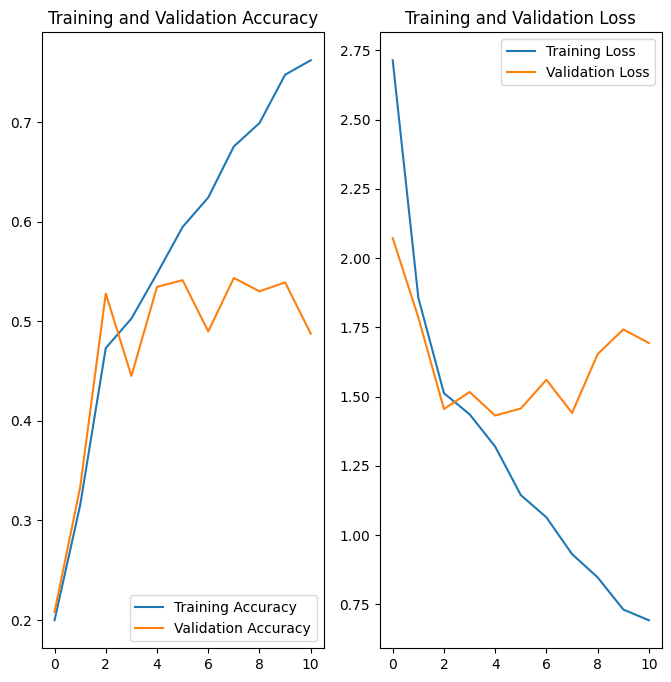

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It can be seen from the above plots that the training accuracy increases, but the validation accuracy is almost stagnant after around 4 epochs. This clearly indicates the case of overfitting when the model LEARNS the training data and prediction capability is less.<br><br>
It can also be seen from the above that the losses in case of training data are decreasing with the epochs, but on the validation data it is increasing.

Overfitting can be reduced by using dropouts, batch normalization and by using image augmentatation methods. <br><br>Let us try with a modified model with dropouts and see the results.

In [44]:
model2 = Sequential()

# model architecture
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))#Using dropouts to reduce the overfitting. random neurons will be turned off and the percentage of turned off neurons will be 20% in this case. This reduces the number of features passed down into the network and prevents the model from learning the data.
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(9))
model2.add(Activation('softmax'))


In [45]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

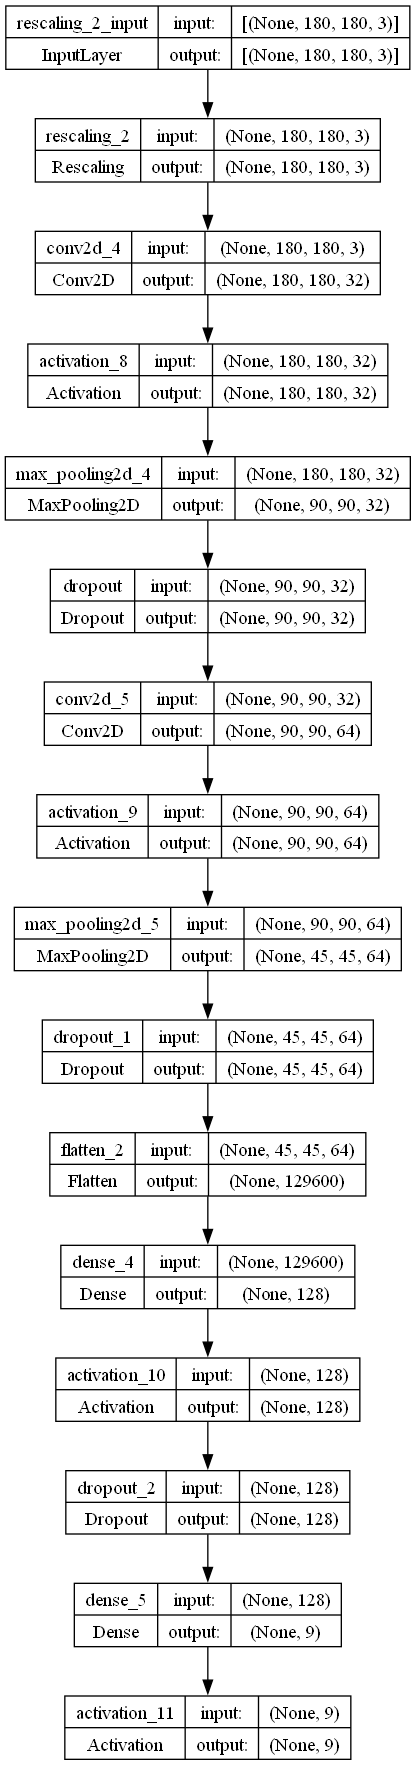

In [46]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [47]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
#setting check points and early stop to monitor the accuracy, save the model when max accuracy is observed ie. when accuracy no more improves. Stops at maximum accuracy observed to save resources and time
checkpoint = ModelCheckpoint("model2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [54]:
#defining the number of epochs, traning dataset, validation dataset, callbacks
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
 2/56 [>.............................] - ETA: 39s - loss: 1.9892 - accuracy: 0.2656

56/56 [==============================] - ETA: 0s - loss: 1.8893 - accuracy: 0.2941
Epoch 1: val_accuracy improved from 0.25280 to 0.32215, saving model to model2.h5


d:\Python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 46s 830ms/step - loss: 1.8893 - accuracy: 0.2941 - val_loss: 1.8627 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7825 - accuracy: 0.3482
Epoch 2: val_accuracy improved from 0.32215 to 0.49888, saving model to model2.h5
56/56 [==============================] - 53s 950ms/step - loss: 1.7825 - accuracy: 0.3482 - val_loss: 1.7383 - val_accuracy: 0.4989
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5925 - accuracy: 0.4358
Epoch 3: val_accuracy did not improve from 0.49888
56/56 [==============================] - 57s 1s/step - loss: 1.5925 - accuracy: 0.4358 - val_loss: 1.5897 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.5185 - accuracy: 0.4570
Epoch 4: val_accuracy improved from 0.49888 to 0.50559, saving model to model2.h5
56/56 [==============================] - 59s 1s/step - loss: 1.5185 - accuracy: 0.4570 - val_loss: 1.6052 - va

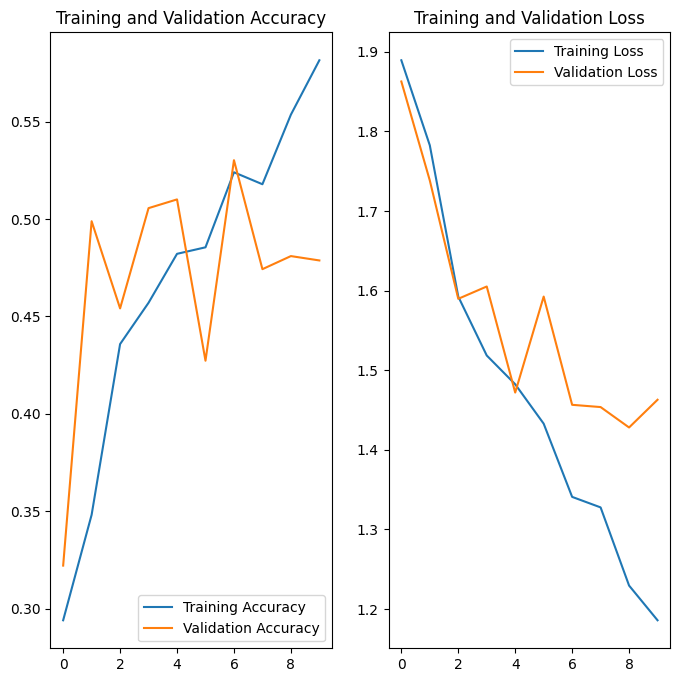

In [55]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The above plots after dropouts still shows that there is overfitting. But still the gap between the training and validation accuracy has reduced.<br><br>The accuracy is still not enough

We can try batch normalization instead of dropouts

In [56]:
model3 = Sequential()

# model architecture
model3.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model3.add(Conv2D(32, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(9))
model3.add(Activation('softmax'))


In [57]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)       

In [58]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [59]:
#setting check points and early stop to monitor the accuracy, save the model when max accuracy is observed ie. when accuracy no more improves. Stops at maximum accuracy observed to save resources and time
checkpoint = ModelCheckpoint("model3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [60]:
#defining the number of epochs, traning dataset, validation dataset, callbacks
epochs = 20
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


56/56 [==============================] - ETA: 0s - loss: 10.6607 - accuracy: 0.2416
Epoch 1: val_accuracy improved from -inf to 0.04922, saving model to model3.h5
56/56 [==============================] - 67s 1s/step - loss: 10.6607 - accuracy: 0.2416 - val_loss: 5.7855 - val_accuracy: 0.0492
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.1758 - accuracy: 0.2333
Epoch 2: val_accuracy did not improve from 0.04922
56/56 [==============================] - 72s 1s/step - loss: 2.1758 - accuracy: 0.2333 - val_loss: 15.3426 - val_accuracy: 0.0492
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 2.0771 - accuracy: 0.2740
Epoch 3: val_accuracy did not improve from 0.04922
56/56 [==============================] - 62s 1s/step - loss: 2.0771 - accuracy: 0.2740 - val_loss: 18.8195 - val_accuracy: 0.0492
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 2.0412 - accuracy: 0.2785
Epoch 4: val_accuracy improved from 0.04922 to 0.05145, saving 

### The code is not run fully for 20 epochs since after 5 epochs it is evident that batch normalization is not helping at all, moreover, the validationa accuracy reduced a lot. Batch normalization is ruled out.

#### Now we'll try data augmentation methods. Augmentation strategy is defined below and the same is used as a layer before rescaling of image colour parameter

In [61]:
#Defining a data augmentation strategy-flipping, random rotation to 0.1 radians, random zoom to 10%, random translations
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
  ]
)

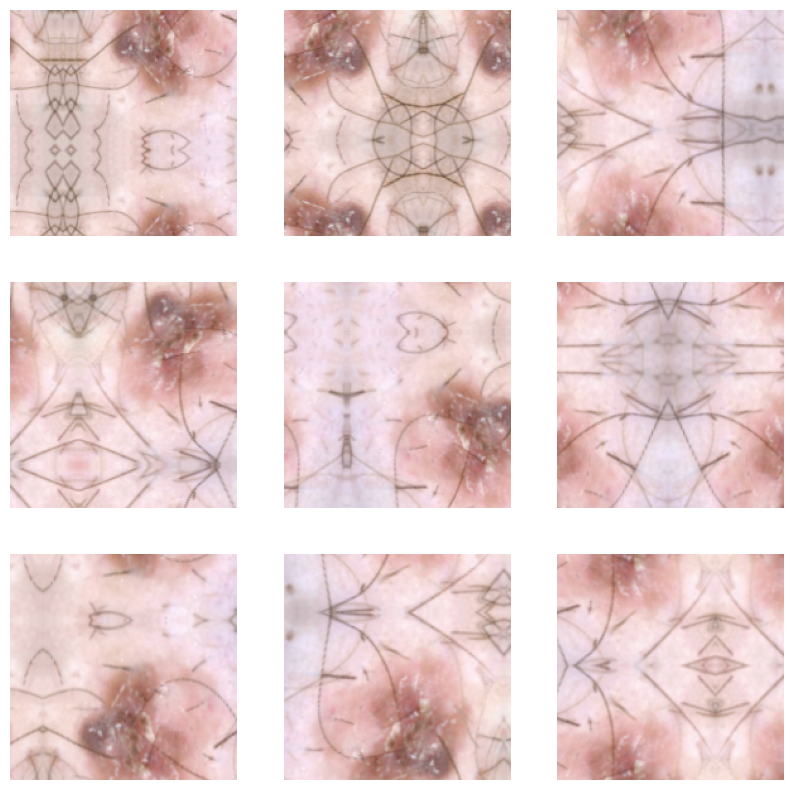

In [62]:
#Visualizing the effect of data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model is redefined by including the data_augmentation and removing the batch normalization. dropuouts are retained

In [63]:
model4 = Sequential()

# model architecture
model4.add(data_augmentation)#Included the augmentation layer which will be run before passing the images to the model.
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model4.add(Conv2D(32, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Flatten())
model4.add(Dense(128))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))
model4.add(Dense(9))
model4.add(Activation('softmax'))


In [64]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_16 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                      

In [65]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [66]:
#setting check points and early stop to monitor the accuracy, save the model when max accuracy is observed ie. when accuracy no more improves. Stops at maximum accuracy observed to save resources and time
checkpoint = ModelCheckpoint("model4.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [67]:
#defining the number of epochs, traning dataset, validation dataset, callbacks
epochs = 20
history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


56/56 [==============================] - ETA: 0s - loss: 3.8141 - accuracy: 0.1708
Epoch 1: val_accuracy improved from -inf to 0.20582, saving model to model4.h5
56/56 [==============================] - 66s 1s/step - loss: 3.8141 - accuracy: 0.1708 - val_loss: 2.0935 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.0603 - accuracy: 0.1975
Epoch 2: val_accuracy did not improve from 0.20582
56/56 [==============================] - 64s 1s/step - loss: 2.0603 - accuracy: 0.1975 - val_loss: 2.0422 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.9833 - accuracy: 0.2461
Epoch 3: val_accuracy improved from 0.20582 to 0.26398, saving model to model4.h5
56/56 [==============================] - 67s 1s/step - loss: 1.9833 - accuracy: 0.2461 - val_loss: 1.9866 - val_accuracy: 0.2640
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.8883 - accuracy: 0.3092
Epoch 4: val_accuracy improved from 

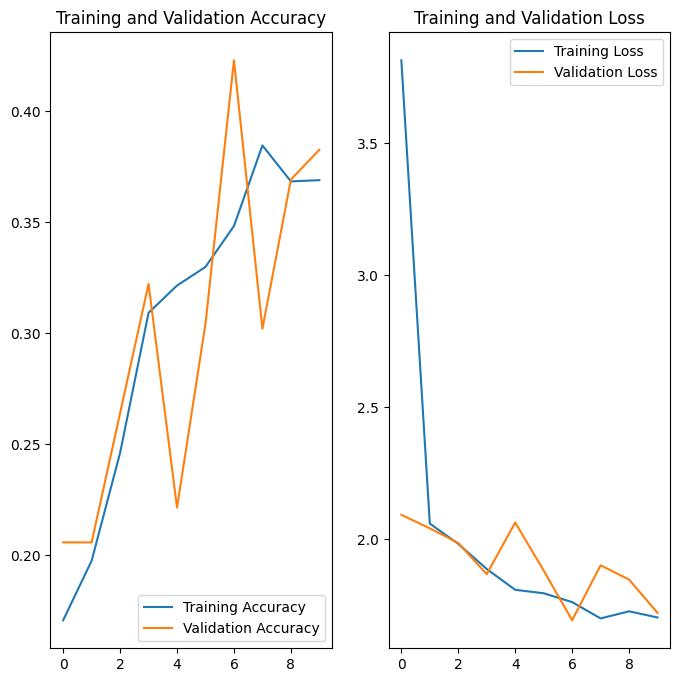

In [68]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the above plots we can see that the overfitting has been reduced. Training and validation accuracies are matching. The strategy used is- dropouts and image augmentation. Batch normalization is NOT USED.<br><br>
#### But the accuracy is still not enough. May be we can check class imbalance and do something to smoothen out class imbalance

In [69]:

#Cycle through the training data folders and find the maximum number of images among each folder
train_data_path = data_dir_train
folders = [f for f in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, f))]

max_images = 0
for folder in folders:
    folder_path = os.path.join(train_data_path, folder)
    num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    max_images = max(max_images, num_images)

max_images


462

In [70]:
# Loop over the classes
class_dict = {}
for class_dir in class_names:
    # Get a list of all the image files for this class
    image_files = os.listdir(os.path.join(data_dir_train, class_dir))
    print(f"Class name: {class_dir} \nTraining data size: {len(image_files)}\n")
    class_dict[class_dir] = len(image_files)

class_dict

Class name: actinic keratosis 
Training data size: 114

Class name: basal cell carcinoma 
Training data size: 376

Class name: dermatofibroma 
Training data size: 95

Class name: melanoma 
Training data size: 438

Class name: nevus 
Training data size: 357

Class name: pigmented benign keratosis 
Training data size: 462

Class name: seborrheic keratosis 
Training data size: 77

Class name: squamous cell carcinoma 
Training data size: 181

Class name: vascular lesion 
Training data size: 139



{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [71]:
#making a dataframe for easy plotting
class_df = pd.DataFrame(list(class_dict.items()), columns=['class_name', 'no. of images'])
class_df

,class_name,no. of images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


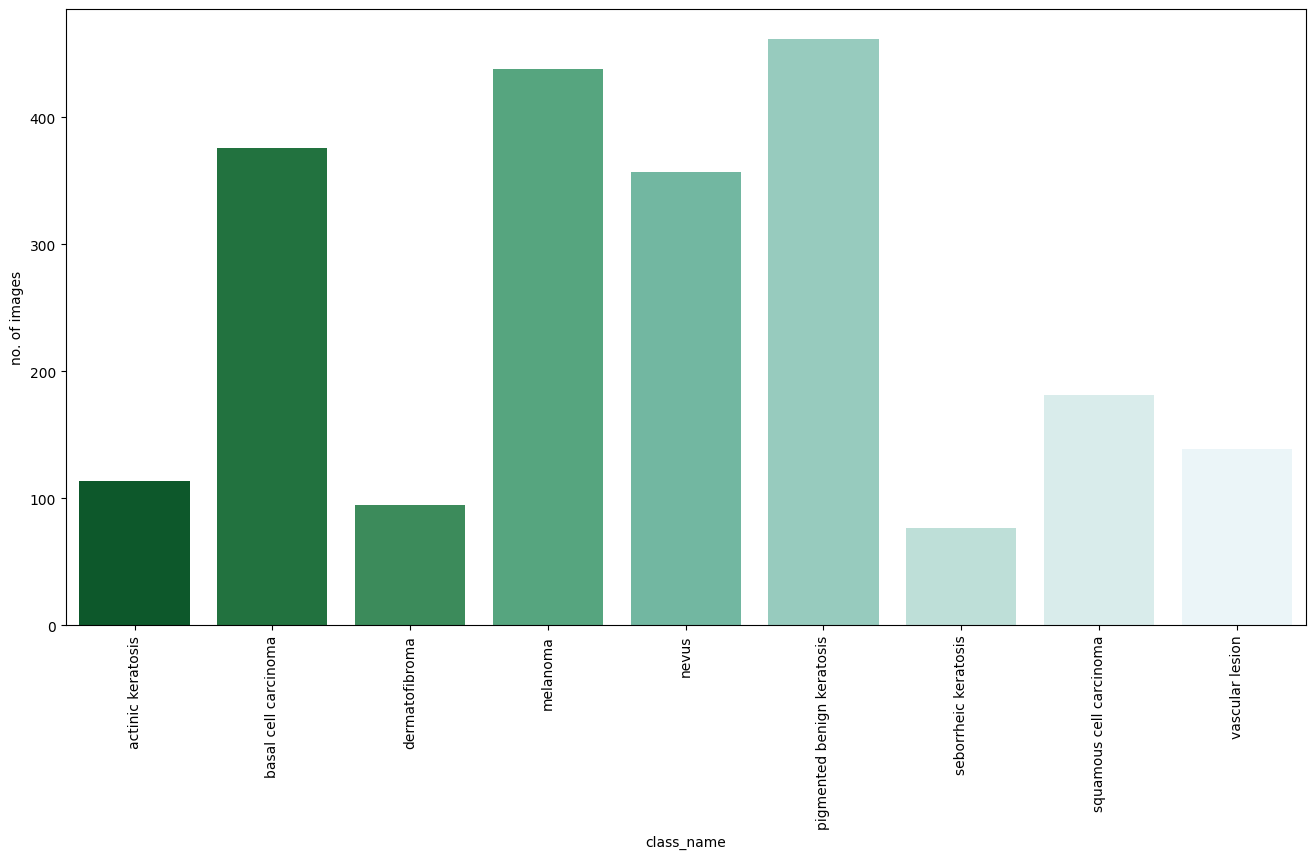

In [72]:
#Plotting the number of images in each class to check the imbalance
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
chart = sns.barplot(class_df, x=class_df['class_name'], y=class_df['no. of images'],
            palette=sns.color_palette("BuGn_r", n_colors=9), hue=class_df['class_name']
            )
chart.tick_params(axis='x', labelrotation=90)
plt.show()

#### From the above it is clear that the the class imabalance is very high. <br>Class 'seborrheic keratosis' has the least number of training data(77 images) and <br> class 'pigmented benign keratosis' has the most number of training data(462 images). 

There are two ways to handle class imbalance by generating new images.<br>
1. Using Keras imagedatagenerator<br>
2. Using augmentor library.

Since it is instructed in the assignment documentation to use augmentor library, we can try using augmentor library.


Trying out with uniform number of images in all classes as 800

In [73]:
#Using the augmentor library to increase and smoothen out the imbalance of the dataset. 
import Augmentor
for class_name in class_names:#For each class in the classes
    p = Augmentor.Pipeline(os.path.join(data_dir_train, class_name))#defining a pipeline
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)#Image transformations with the probability of an image being applied with this or not
    p.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)#Image zooming
    p.zoom(probability=0.7, min_factor=1.1, max_factor=1.2)#image zooming
    p.crop_random(probability=0.7, percentage_area=0.8)#image cropping to 80%
    p.flip_left_right(probability=1)#Image flipping horizontally
    image_files = os.listdir(os.path.join(data_dir_train, class_name))
    size = len(image_files)
    p.sample(801-size)#Since the max limit is set a 800 images per class

Initialised with 114 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=480x360 at 0x2A84E0F0AF0>: 100%|██████████| 686/686 [00:06<00:00, 114.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=480x360 at 0x2A84E0FE760>: 100%|██████████| 424/424 [00:03<00:00, 118.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A83B9AB250>: 100%|██████████| 705/705 [00:06<00:00, 102.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x2A84C611C10>: 100%|██████████| 362/362 [00:26<00:00, 13.74 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2A84C66A9D0>: 100%|██████████| 443/443 [00:26<00:00, 17.01 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=480x360 at 0x2A83B93E0A0>: 100%|██████████| 338/338 [00:04<00:00, 84.07 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x2A83B984940>: 100%|██████████| 723/723 [00:16<00:00, 44.46 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=480x360 at 0x2A83B93E130>: 100%|██████████| 619/619 [00:05<00:00, 103.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to D:\Upgrad\Assignment-Melanoma detection\Skin cancer ISIC The International Skin Imaging Collaboration\train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A83B7DF6D0>: 100%|██████████| 661/661 [00:06<00:00, 96.83 Samples/s] 


In [74]:
len(glob.glob(os.path.join(data_dir_train, '**', '*.jpg'), recursive=True))

7200

#### Checking data imbalance again

In [75]:
# Loop over the classes
class_dict = {}
for class_dir in class_names:
    # Get a list of all the image files for this class
    dir_path = os.path.join(data_dir_train, class_name, '**', '*.jpg')
    data_size = len(glob.glob(dir_path, recursive=True))
    class_dict[class_dir] = data_size

class_dict

{'actinic keratosis': 800,
 'basal cell carcinoma': 800,
 'dermatofibroma': 800,
 'melanoma': 800,
 'nevus': 800,
 'pigmented benign keratosis': 800,
 'seborrheic keratosis': 800,
 'squamous cell carcinoma': 800,
 'vascular lesion': 800}

In [76]:
class_df = pd.DataFrame(list(class_dict.items()), columns=['class_name', 'no. of images'])
class_df

,class_name,no. of images
0,actinic keratosis,800
1,basal cell carcinoma,800
2,dermatofibroma,800
3,melanoma,800
4,nevus,800
5,pigmented benign keratosis,800
6,seborrheic keratosis,800
7,squamous cell carcinoma,800
8,vascular lesion,800


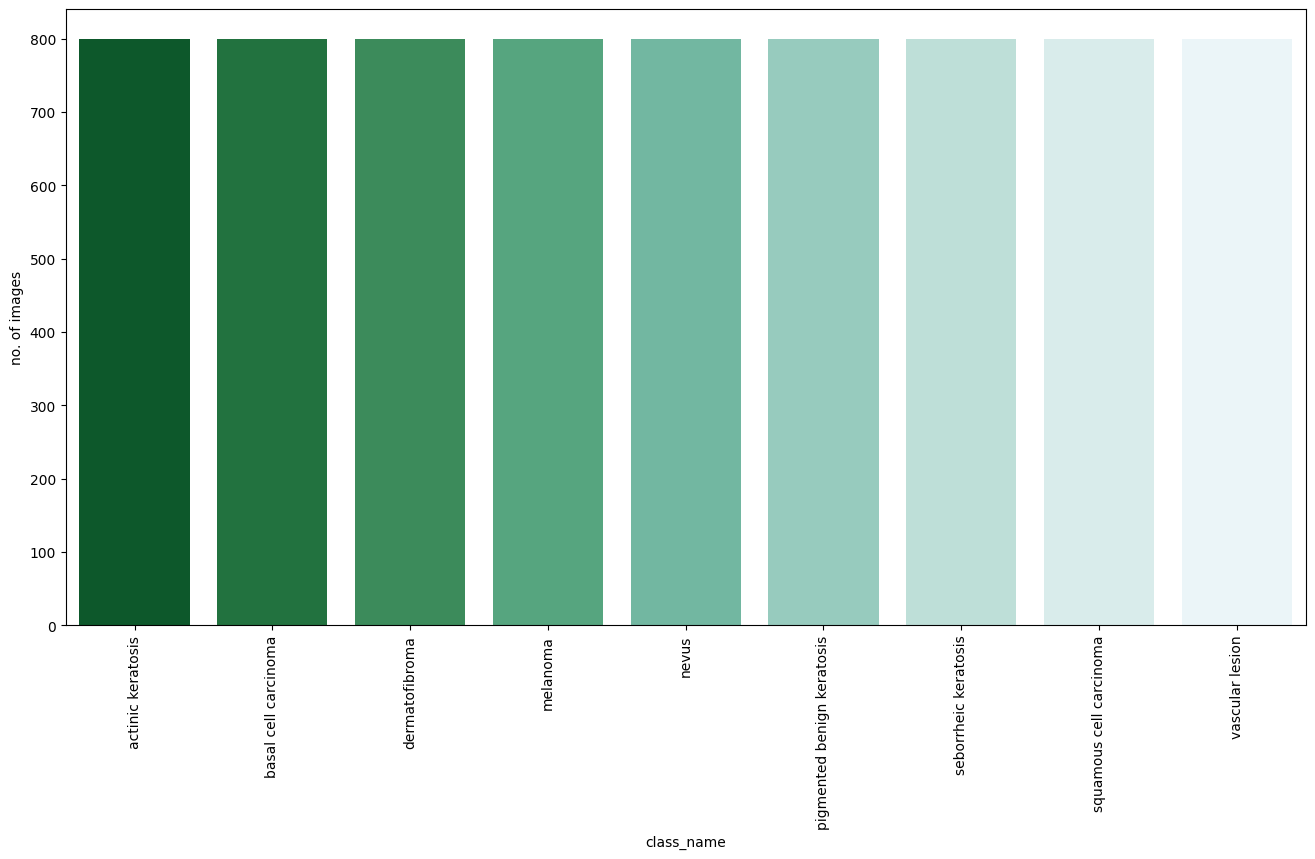

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
chart = sns.barplot(class_df, x=class_df['class_name'], y=class_df['no. of images'],
            palette=sns.color_palette("BuGn_r", n_colors=9), hue=class_df['class_name']
            )
chart.tick_params(axis='x', labelrotation=90)
plt.show()

### From the above, it can be seen that there is no data imbalance in the training data set. Imbalance is rectified using augmentor library<br>
### Now we can try training the model and check the accuracies

Redefining train_ds and val_ds after using augmentor since there is an increase in the number of the training data images

In [78]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = data_dir_train, image_size = (img_height, img_width), seed = 123, validation_split = 0.2, subset = 'training' )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = data_dir_train, image_size = (img_height, img_width), seed = 123, validation_split = 0.2, subset = 'validation' )

Found 7200 files belonging to 9 classes.
Using 5760 files for training.
Found 7200 files belonging to 9 classes.
Using 1440 files for validation.


In [79]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [80]:
model5 = Sequential()

# model architecture
model5.add(data_augmentation)
model5.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model5.add(Conv2D(16, (3, 3), padding='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(32, (3, 3), padding='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(64, (3, 3), padding='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Dropout(0.2))

model5.add(Flatten())
model5.add(Dense(128))
model5.add(Activation('relu'))


model5.add(Dense(9))
model5.add(Activation('softmax'))


In [81]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_20 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

In [82]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [83]:
checkpoint = ModelCheckpoint("model5.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [84]:
epochs = 20
history5 = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


180/180 [==============================] - ETA: 0s - loss: 2.0567 - accuracy: 0.1842
Epoch 1: val_accuracy improved from -inf to 0.27222, saving model to model5.h5
180/180 [==============================] - 105s 504ms/step - loss: 2.0567 - accuracy: 0.1842 - val_loss: 1.7959 - val_accuracy: 0.2722
Epoch 2/20


d:\Python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - ETA: 0s - loss: 1.7548 - accuracy: 0.3066
Epoch 2: val_accuracy improved from 0.27222 to 0.32847, saving model to model5.h5
180/180 [==============================] - 92s 509ms/step - loss: 1.7548 - accuracy: 0.3066 - val_loss: 1.6752 - val_accuracy: 0.3285
Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 1.6651 - accuracy: 0.3550
Epoch 3: val_accuracy improved from 0.32847 to 0.34653, saving model to model5.h5
180/180 [==============================] - 88s 491ms/step - loss: 1.6651 - accuracy: 0.3550 - val_loss: 1.6076 - val_accuracy: 0.3465
Epoch 4/20
180/180 [==============================] - ETA: 0s - loss: 1.5804 - accuracy: 0.3823
Epoch 4: val_accuracy improved from 0.34653 to 0.39861, saving model to model5.h5
180/180 [==============================] - 93s 518ms/step - loss: 1.5804 - accuracy: 0.3823 - val_loss: 1.5262 - val_accuracy: 0.3986
Epoch 5/20
180/180 [==============================] - ETA: 0s - loss: 1.571

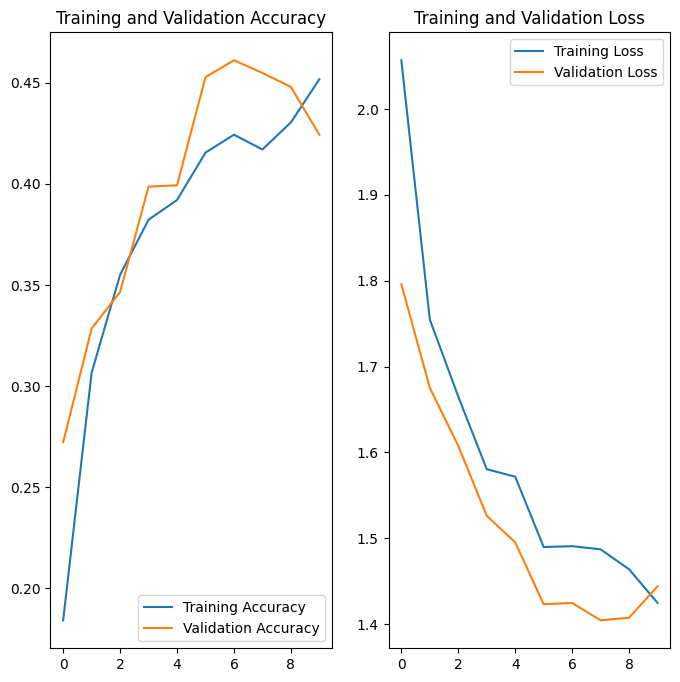

In [85]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
model6 = Sequential()

# model architecture

model6.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model6.add(Conv2D(16, (3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(32, (3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(64, (3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Dropout(0.2))

model6.add(Flatten())
model6.add(Dense(128))
model6.add(Activation('relu'))


model6.add(Dense(9))
model6.add(Activation('softmax'))


In [87]:
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_25 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 activation_26 (Activation)  (None, 90, 90, 32)        0         
                                                      

In [88]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model6.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [89]:
checkpoint = ModelCheckpoint("model6.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [90]:
epochs = 20
history6 = model6.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


180/180 [==============================] - ETA: 0s - loss: 2.0213 - accuracy: 0.2271
Epoch 1: val_accuracy improved from -inf to 0.29236, saving model to model6.h5
180/180 [==============================] - 89s 486ms/step - loss: 2.0213 - accuracy: 0.2271 - val_loss: 1.8569 - val_accuracy: 0.2924
Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 1.5898 - accuracy: 0.3955
Epoch 2: val_accuracy improved from 0.29236 to 0.40625, saving model to model6.h5
180/180 [==============================] - 84s 467ms/step - loss: 1.5898 - accuracy: 0.3955 - val_loss: 1.5259 - val_accuracy: 0.4062
Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 1.4440 - accuracy: 0.4615
Epoch 3: val_accuracy improved from 0.40625 to 0.51319, saving model to model6.h5
180/180 [==============================] - 81s 451ms/step - loss: 1.4440 - accuracy: 0.4615 - val_loss: 1.3590 - val_accuracy: 0.5132
Epoch 4/20
180/180 [==============================] - ETA: 0s - loss: 1.3279 -

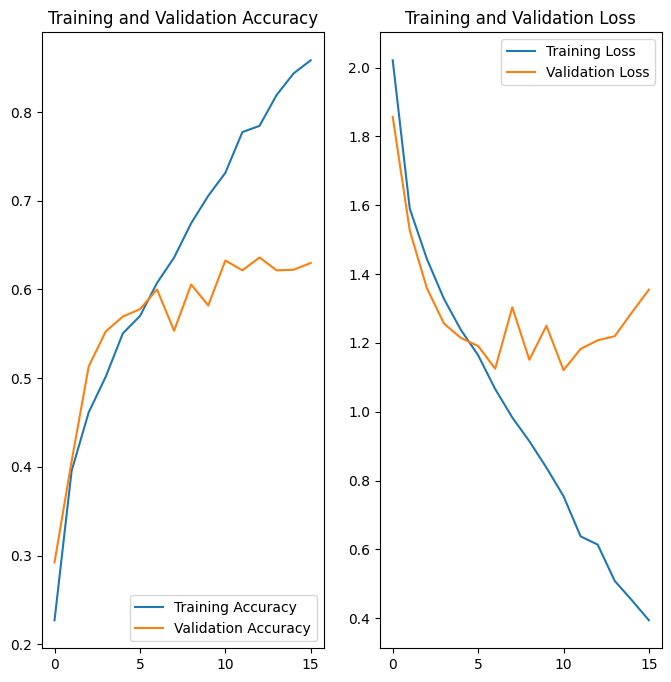

In [91]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [92]:
model7 = Sequential()

# model architecture
model7.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model7.add(Conv2D(16, (3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(32, (3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(64, (3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Flatten())
model7.add(Dense(128))
model7.add(Activation('relu'))
model7.add(Dropout(0.5))


model7.add(Dense(9))
model7.add(Activation('softmax'))


In [93]:
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_30 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

In [94]:
### Sparse_categorical_crossentropy is chosen since the class labels are integer encoded. 
model7.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [95]:
#setting check points and early stop to monitor the accuracy, save the model when max accuracy is observed ie. when accuracy no more improves. Stops at maximum accuracy observed to save resources and time
checkpoint = ModelCheckpoint("model7.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [96]:
#defining the number of epochs, traning dataset, validation dataset, callbacks
epochs = 20
history7 = model7.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


180/180 [==============================] - ETA: 0s - loss: 2.1879 - accuracy: 0.1594
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to model7.h5
180/180 [==============================] - 98s 538ms/step - loss: 2.1879 - accuracy: 0.1594 - val_loss: 1.9834 - val_accuracy: 0.2361
Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 1.7630 - accuracy: 0.3073
Epoch 2: val_accuracy improved from 0.23611 to 0.38611, saving model to model7.h5
180/180 [==============================] - 87s 482ms/step - loss: 1.7630 - accuracy: 0.3073 - val_loss: 1.6371 - val_accuracy: 0.3861
Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 1.6606 - accuracy: 0.3611
Epoch 3: val_accuracy improved from 0.38611 to 0.44306, saving model to model7.h5
180/180 [==============================] - 90s 503ms/step - loss: 1.6606 - accuracy: 0.3611 - val_loss: 1.4846 - val_accuracy: 0.4431
Epoch 4/20
180/180 [==============================] - ETA: 0s - loss: 1.5544 -

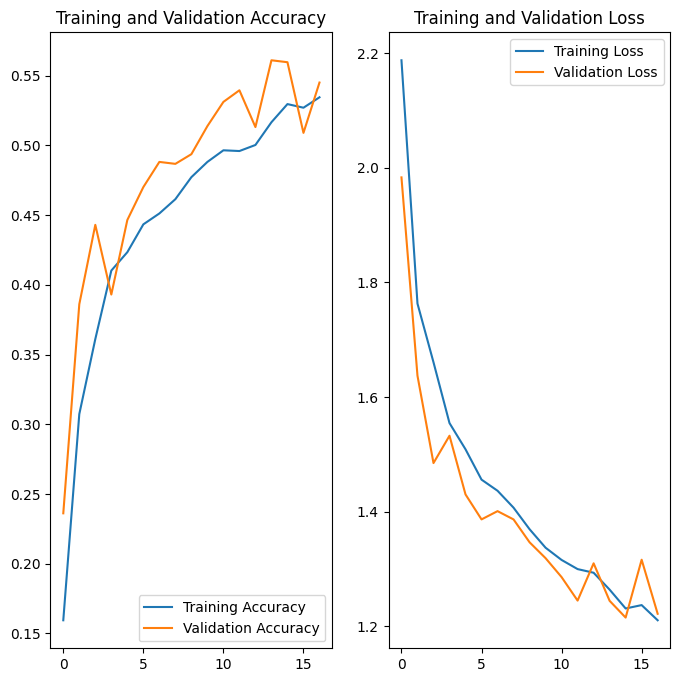

In [97]:
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Code to determine the best accurate model based on the validation accuracies

In [98]:
history_list = [history, history2, history3, history4, history5, history6, history7]

max_accuracy = 0
model_name = None

for hist in history_list:
    accuracy = max(hist.history['val_accuracy'])
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        index = history_list.index(hist)
        model_name = f"model{index+1}"           

print(f"max_accuracy: {max_accuracy}")
print(f"best model: {model_name}")

max_accuracy: 0.6361111402511597
best model: model6


#### Prediction using the model with the best validation accuracy(Note: validation accuracy is very low, reaons mentioned in inferences and observations given below)

In [101]:
import math
# Load the trained model
model = load_model(f'{model_name}.h5')
# Predict classes
predictions = model.predict_generator(test_generator, steps=math.ceil(test_generator.samples / test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate overall accuracy
accuracy = np.sum(predicted_classes == test_generator.classes) / len(test_generator.classes)
print(f"Overall accuracy: {accuracy}")

C:\Users\SreekumarRadhakrishn\AppData\Local\Temp\ipykernel_34200\897103141.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=math.ceil(test_generator.samples / test_generator.batch_size), verbose=1)


4/4 [==============================] - 3s 1s/step
Overall accuracy: 0.025423728813559324


In [102]:
model = load_model(f'{model_name}.h5')#loading the model with the best validation accuracy
# Define the ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Predict classes
predictions = model.predict_generator(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate overall accuracy
accuracy = np.sum(predicted_classes == test_generator.classes) / len(test_generator.classes)
print(f"Overall accuracy: {accuracy}")

Found 118 images belonging to 9 classes.


C:\Users\SreekumarRadhakrishn\AppData\Local\Temp\ipykernel_34200\703801336.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)


3/3 [==============================] - 2s 888ms/step
Overall accuracy: 0.0


C:\Users\SreekumarRadhakrishn\AppData\Local\Temp\ipykernel_34200\703801336.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(predicted_classes == test_generator.classes) / len(test_generator.classes)


#### Since the model was not trained with a large amount of data, even the best model among the 7 different models has low test accuracy inherently. Due to resource constraints(high end GPU), restricted google colab access, thousands of images could not be generated and therefore such models couldn't be trained and tested.

#### Code to increase the number of images to 10000 in each class in training data using augmentor

In [ ]:
#Using the augmentor library to increase and smoothen out the imbalance of the dataset. 

for class_name in class_names:#For each class in the classes
    p = Augmentor.Pipeline(os.path.join(data_dir_train, class_name))#defining a pipeline
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)#Image transformations with the probability of an image being applied with this or not
    p.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)#Image zooming
    p.zoom(probability=0.7, min_factor=1.1, max_factor=1.2)#image zooming
    p.crop_random(probability=0.7, percentage_area=0.8)#image cropping to 80%
    p.flip_left_right(probability=1)#Image flipping horizontally
    image_files = os.listdir(os.path.join(data_dir_train, class_name))
    size = len(image_files)
    p.sample(10001-size)#Since the max limit is set a 800 images per class

#### Using model6 architecture again to train the model. model6 architecture is chosen since it was observed to give the best validation accuracy, but naming the model to model8

In [ ]:
model8 = Sequential()

# model architecture

model8.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))#Add input shape here else model will throw an error
model8.add(Conv2D(16, (3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))

model8.add(Conv2D(32, (3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))

model8.add(Conv2D(64, (3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))

model8.add(Dropout(0.2))

model8.add(Flatten())
model8.add(Dense(128))
model8.add(Activation('relu'))


model8.add(Dense(9))
model8.add(Activation('softmax'))


In [ ]:
model8.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_32 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_93 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_157 (Activation  (None, 180, 180, 16)      0         
 )                                                               
                                                                 
 max_pooling2d_93 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 activation_158 (Activation  (None, 90, 90, 32)      

In [ ]:
#setting check points and early stop to monitor the accuracy, save the model when max accuracy is observed ie. when accuracy no more improves. Stops at maximum accuracy observed to save resources and time
checkpoint = ModelCheckpoint("model8.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="auto",verbose=1)

In [ ]:
#defining the number of epochs, traning dataset, validation dataset, callbacks
epochs = 20
history8 = model8.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,  
  callbacks=[checkpoint,earlystop]
)

Validation accuracy for the model trained in 10000 images per class

In [ ]:
#validation accuracy after increasing the number of training data images:
best_val_accuracy = history8.history['val_accuracy']
print(f"Best validation accuracy: {best_val_accuracy}")

#### Predictions using the new model

In [ ]:
model = load_model(model8)#loading the model with the best validation accuracy
# Define the ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Predict classes
predictions = model.predict_generator(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate overall accuracy
accuracy = np.sum(predicted_classes == test_generator.classes) / len(test_generator.classes)
print(f"Overall accuracy: {accuracy}")

## Observations and inferences<br><br> 
#### A total of 7 nos models were tried out<br>- The initial results with the raw set of imbalanced data had greater accuracy for the validation dataset. But there was overfitting observed.<br>- Then tried various options to bring down overfitting. <br>- First tried dropouts, there was no overfitting, but the accuracy was not high<br> Then tried batch normalization without dropouts, found that batch normalization wont help<br>- The tried image augmentation with dropouts. <br>- There was slight increase in accuracy and less overfitting. Still the accuracy levels were not enough.<br>- It was observed there was severe class imbalance which could have affected the training and the accuracy<br>- Then tried the image augmentor library, used to generate additional image for each class. The number of images were capped at 800 for each class. Now the there is no imbalance in the data.<br>- But upon training the model, it was found that there was no improvement in accuracy, the accuracy levels are less than acceptable, but there was no overfitting.<br>- It was also observed that in the final model utilizing the augmentor generated images for smoothening out the imbalance, augmentation at the beginning of the model is doing more harm than good. The accuracy is better when the first layer is NOT image augmentation.<br>- The best model was found to be the one with dropouts, 3 layers of CNN, two layers of dense layers, and without image augmentation at the beginning.<br>- <span style="color:red">*It is also oberved that 800 images in each class might not be enough to get good accuracy. Due resource constraints(lack of High end GPU), restricted google colab access, generating a large number of data(images) in the order of tens of thousands was not attempted.*</span><br>- Since the model was not trained with a large amount of data, even the best model among the 7 different models has low test accuracy inherently.

### Image datagenerator code is given below. But not tried out since augmentor library was mentioned in the instructions

In [ ]:
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.3
)

In [ ]:
class_dirs = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]
class_dirs

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
max_images = max([len(os.listdir(os.path.join(data_dir_train, d))) for d in class_dirs])
max_images

463

In [ ]:
# Loop over the classes
for class_dir in class_names:
    # Get a list of all the image files for this class
    image_files = os.listdir(os.path.join(data_dir_train, class_dir))
    print(len(image_files))

115
377
96
439
358
463
78
182
140


In [ ]:
class_dirs = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

# Find the maximum number of images in the subfolders- max images is set to the maxmimum value among each class. This can be increased to absolute values like 800 as requried. 
max_images = max([len(os.listdir(os.path.join(data_dir_train, d))) for d in class_dirs])
# Loop over the classes
for class_dir in class_dirs:
    # Get a list of all the image files for this class
    image_files = os.listdir(os.path.join(data_dir_train, class_dir))
    initial_length = len(image_files)
    print(f"Class Dir = {class_dir}\nInitial length: {len(image_files)}\nMax_images: {max_images}")
    
           # Loop over the images
    for image_file in image_files:
        # Load the image
        img = keras.preprocessing.image.load_img(os.path.join(data_dir_train, class_dir, image_file))
        img = keras.preprocessing.image.img_to_array(img)
                
            # Expand dimensions
        img = np.expand_dims(img, axis=0)
                
            # Generate augmented images using the flow iterator
        aug_iter = data_gen.flow(img, batch_size=1, save_to_dir=os.path.join(data_dir_train, class_dir), save_prefix='aug', save_format='jpeg')
        if len(image_files) < max_images:
            next(aug_iter)
            image_files = os.listdir(os.path.join(data_dir_train, class_dir))
        else:
            print(f"Augmented nos: {len(image_files)}\n Class dir: {class_dir}")
            break            

In [ ]:
# Loop over the classes
for class_dir in class_dirs:
    # Get a list of all the image files for this class
    image_files = os.listdir(os.path.join(data_dir_train, class_dir))
    print(len(image_files))

462
462
462
462
462
462
462
462
462


### In the above code, the max no. of images is capped at 462, the max among the number of classes. then the same cycles can be tried out-model building, training etc